# **Urbain Mahecor DIAGNE Master 2 BI & Big Data**
## Numéro Etudiant: 221537


# **Examen Introduction à la Big Data**

### **Source de données**

L'objectif de ce projet est de construire un modèle de détection de fraude bancaire en utilisant Spark ML. Le modèle prendra en entrée un ensemble de caractéristiques liées à une transaction (par exemple, le montant de la transaction, le pays de l'émetteur, le type de carte, etc.) et prédira si la transaction est frauduleuse ou non.

### **Exploration des données**

L'ensemble de données contient les transactions effectuées par carte de crédit en septembre 2013 par des titulaires de cartes européens. Cet ensemble de données présente les transactions survenues en deux jours, où nous avons 492 fraudes sur 284 807 transactions. L'ensemble de données est très déséquilibré, la classe positive (fraudes) représentant 0,172% de toutes les transactions.

Il contient uniquement des variables d'entrée numériques qui sont le résultat d'une transformation ACP. Malheureusement, en raison de problèmes de confidentialité, nous ne pouvons pas fournir les caractéristiques originales ni davantage d'informations générales sur les données. Les fonctionnalités V1, V2, … V28 sont les principales composantes obtenues avec ACP, les seules fonctionnalités qui n'ont pas été transformées avec ACP sont 'Time' et 'Amount'. La fonctionnalité « Time » contient les secondes écoulées entre chaque transaction et la première transaction de l'ensemble de données. La fonctionnalité « Montant » correspond au montant de la transaction. Cette fonctionnalité peut être utilisée pour un apprentissage sensible aux coûts, en fonction d'un exemple. La fonctionnalité « Class » est la variable de réponse et elle prend la valeur 1 en cas de fraude et 0 sinon.

### **Préparation des données**

#### **Importation des bibliothèques requises**

In [2]:
# Install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=312ff1c8dbc84b7486b8e278ca26ecefd7e15dca40a517b0a1e53085829aff20
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [6]:
!pip install findspark

In [4]:
# Import PySpark
from pyspark.sql import SparkSession

In [7]:
import findspark
findspark.init()
import pyspark
conf = pyspark.SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '10G')
        .set('spark.driver.maxResultSize', '10G'))
sc = pyspark.SparkContext(conf=conf)
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
sqlc = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#### **Importation des données**

In [10]:
data = spark.read.format("csv").option("header","true").load("creditcard.csv")

In [57]:
data.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [46]:
len(data.columns)

32

In [48]:
data.head(5)

[Row(Time=0.0, V1=-1.3598071336738, V2=-0.0727811733098497, V3=2.53634673796914, V4=1.37815522427443, V5=-0.338320769942518, V6=0.462387777762292, V7=0.239598554061257, V8=0.0986979012610507, V9=0.363786969611213, V10=0.0907941719789316, V11=-0.551599533260813, V12=-0.617800855762348, V13=-0.991389847235408, V14=-0.311169353699879, V15=1.46817697209427, V16=-0.470400525259478, V17=0.207971241929242, V18=0.0257905801985591, V19=0.403992960255733, V20=0.251412098239705, V21=-0.018306777944153, V22=0.277837575558899, V23=-0.110473910188767, V24=0.0669280749146731, V25=0.128539358273528, V26=-0.189114843888824, V27=0.133558376740387, V28=-0.0210530534538215, Amount=149.62, Class=0.0, idx=1),
 Row(Time=0.0, V1=1.19185711131486, V2=0.26615071205963, V3=0.16648011335321, V4=0.448154078460911, V5=0.0600176492822243, V6=-0.0823608088155687, V7=-0.0788029833323113, V8=0.0851016549148104, V9=-0.255425128109186, V10=-0.166974414004614, V11=1.61272666105479, V12=1.06523531137287, V13=0.489095015896

Pour un rendu juste nous allons juste visualisé une partie du dataframe data

In [49]:
data.select(
    "Time",
    "V1",
    "V2",
    "V3",
    "Amount",
    "Class"
).show()

+----+------------------+-------------------+------------------+------+-----+
|Time|                V1|                 V2|                V3|Amount|Class|
+----+------------------+-------------------+------------------+------+-----+
| 0.0|  -1.3598071336738|-0.0727811733098497|  2.53634673796914|149.62|  0.0|
| 0.0|  1.19185711131486|   0.26615071205963|  0.16648011335321|  2.69|  0.0|
| 1.0| -1.35835406159823|  -1.34016307473609|  1.77320934263119|378.66|  0.0|
| 1.0|-0.966271711572087| -0.185226008082898|  1.79299333957872| 123.5|  0.0|
| 2.0| -1.15823309349523|  0.877736754848451|    1.548717846511| 69.99|  0.0|
| 2.0|-0.425965884412454|  0.960523044882985|  1.14110934232219|  3.67|  0.0|
| 4.0|  1.22965763450793|  0.141003507049326|0.0453707735899449|  4.99|  0.0|
| 7.0|-0.644269442348146|   1.41796354547385|   1.0743803763556|  40.8|  0.0|
| 7.0| -0.89428608220282|  0.286157196276544|-0.113192212729871|  93.2|  0.0|
| 9.0| -0.33826175242575|   1.11959337641566|  1.04436655157316|

In [58]:
data.describe().show()

+-------+------------------+--------------------+-------------------+------------------+-------------------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+------------------+
|summary|              Time|                  V1|                 V2|                V3|                 V4|                  V5|                V6|                  V7|                  V8|                 V9|                V10|                V11|                V12|                V13|                V14|                V15|           

#### **Vérification de la fréquence Classe**

In [11]:
classFreq = data.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    0|158246|
|    1|   356|
+-----+------+



In [12]:
toPlot = classFreq.toPandas()

<Axes: xlabel='Class'>

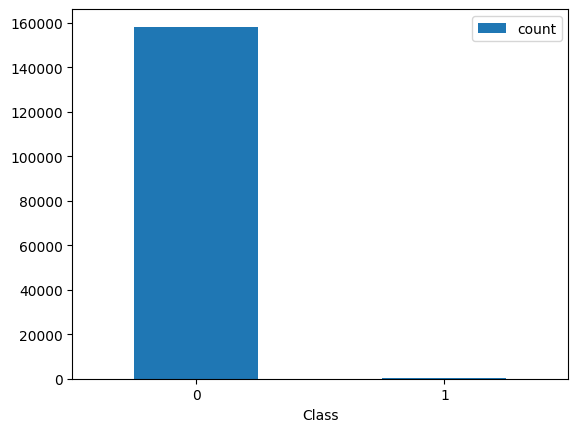

In [13]:
toPlot.plot.bar(x='Class', y='count',rot=0)

#### **Conversion du type de données String des colonnes en double**

In [14]:
for column in data.columns:
    data = data.withColumn(column,data[column].cast("double"))

#### **Ajout d'un index pour garder une trace des lignes même après une lecture aléatoire**

In [15]:
from pyspark.sql.window import Window
win = Window().orderBy('Time')
data = data.withColumn("idx", row_number().over(win))

#### **Importation des méthodes de bibliothèque Spark ML requises**

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

#### **Conversion des colonnes de fonctionnalités en vecteur et création de colonnes d'étiquettes et d'index**

In [18]:
training_df = data.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))

In [19]:
training_df = spark.createDataFrame(training_df,["features","label","index"])

In [20]:
training_df = training_df.select("index","features","label")

#### **Diviser les données en données d'entrainement et de test**

In [21]:
train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [22]:
train_data.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|126727|
|  1.0|   285|
+-----+------+



In [23]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|31519|
|  1.0|   71|
+-----+-----+



#### **Création d'un Gradient Boosting Trees Classifier Model pour ajuster et prédire les données**

In [24]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)

In [25]:
model = gbt.fit(train_data)

In [26]:
predictions = model.transform(test_data)

#### **Vérification du nombre d'enregistrements classés dans chaque classe**

In [27]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|31525|
|       1.0|   65|
+----------+-----+



#### **Calcul de la précision du modèle**
#### **A noté que cela peut être trompeur en raison du déséquilibre des classes**

In [28]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9490644811155741

#### **Calcul du pourcentage d'enregistrements de fraude prédit correctement**

In [29]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))

In [30]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   55|
|              0|31535|
+---------------+-----+



In [31]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|31519|
|  1.0|   71|
+-----+-----+



In [32]:
from pyspark.sql.functions import col

In [33]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

In [34]:
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]

In [35]:
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

In [36]:
FraudPredictionAccuracy

77.46478873239437

#### **Calcul da la matrice de confusion**

In [37]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

In [38]:
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

In [39]:
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

In [40]:
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [41]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)

True Positive:  55 
True Negative:  31509 
False Positive:  10 
False Negative:  16


### **Calcul du Rappel**

In [42]:
print("Recall: ",tp/(tp+fn))

Recall:  0.7746478873239436


### Calcul de la précision

In [43]:
print("Precision: ", tp/(tp+fp))

Precision:  0.8461538461538461


#### **Clacul du F1-score**

In [64]:

Precision = tp / (tp + fp)


Recall = tp / (tp + fn)


f1 = 2 * (Precision * Recall) / (Precision + Recall)

print("F1-score:", f1)

F1-score: 0.8088235294117647
